<a href="https://colab.research.google.com/github/arthurpeter/Machine_Learning/blob/main/DSM_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSM
## Self-supervised contrastive learning with SimCLR

In this lab, we will explore the implementation of SimCLR, a method for self-supervised pretraining of networks.

We will perform our pretraining on CIFAR10, a dataset of natural images, and then fine tune our network on SVHN, a dataset of pictures of house numbers.

You can find the original paper here: A Simple Framework for Contrastive Learning of Visual Representations (https://arxiv.org/abs/2002.05709)



First off, lets define the training and validation loops for normal, supervised classification.

In [1]:
import sys

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, dataloader, device, optimizer, criterion, epoch):
    model.train()

    total_train_loss = 0.0
    dataset_size = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        optimizer.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        total_train_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_train_loss / dataset_size, 2)
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)


    return epoch_loss

def valid_epoch(model, dataloader, device, criterion, epoch):
    model.eval()

    total_val_loss = 0.0
    dataset_size = 0

    correct = 0

    bar = tqdm(enumerate(dataloader), total=len(dataloader), colour='cyan', file=sys.stdout)
    for step, (images, labels) in bar:
        images = images.to(device)
        labels = labels.to(device)

        batch_size = images.shape[0]

        pred = model(images)
        loss = criterion(pred, labels)

        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels).sum().item()

        total_val_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = np.round(total_val_loss / dataset_size, 2)

        accuracy = np.round(100 * correct / dataset_size, 2)

        bar.set_postfix(Epoch=epoch, Valid_Acc=accuracy, Valid_Loss=epoch_loss)

    return accuracy, epoch_loss

def run_training(model, trainloader, testloader, criterion, optimizer, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    top_accuracy = 0.0

    for epoch in range(num_epochs):

        train_loss = train_epoch(model, trainloader, device, optimizer, criterion, epoch)
        with torch.no_grad():
            val_accuracy, val_loss = valid_epoch(model, testloader, device, criterion, epoch)
            if val_accuracy > top_accuracy:
                print(f"Validation Accuracy Improved ({top_accuracy} ---> {val_accuracy})")
                top_accuracy = val_accuracy
        print()

In [5]:
# TODO - Add more transforms that act as image augmentations
# Remember that Self-Supervised methods benefit greatly from "heavier" data augmentations
# Checkout https://pytorch.org/vision/0.9/transforms.html
# Or search on google for a SimCLR implementation and copy their transforms from there

# Add horizontal flips, random resized crops, color jitter, grayscale etc.
# transforms.RandomHorizontalFlip( ... )
# transforms.RandomResizedCrop(... ) # images should remain at 32x32
# transforms.RandomRotation(...)
# transforms.ColorJitter(...)
# transforms.RandomGrayscale(...)


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Define SVHN dataset (the final, downstream one)
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Let's just use 10% of the data to make it harder
# TODO test what happens with even fewer data, like 1%, 5% etc.
from collections import defaultdict
indices_per_class = defaultdict(list)
for i in range(len(svhn_trainset)):
  _, class_label = svhn_trainset[i]
  indices_per_class[class_label].append(i)

final_indices = []
for class_name, indices in indices_per_class.items():
  sampled_indices = indices[:int(0.1 * len(indices))]
  final_indices.extend(sampled_indices)

svhn_trainset = torch.utils.data.Subset(dataset = svhn_trainset, indices = final_indices)

svhn_trainloader = DataLoader(svhn_trainset, batch_size=256, shuffle=True)
svhn_testloader = DataLoader(svhn_testset, batch_size=256, shuffle=False)


    frog     frog     ship     frog     deer      dog    truck     ship


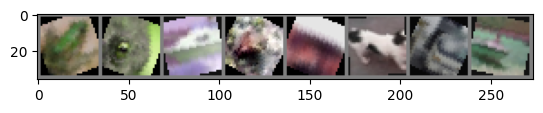

SVHN
       2        3        6        7        6        7        7        7


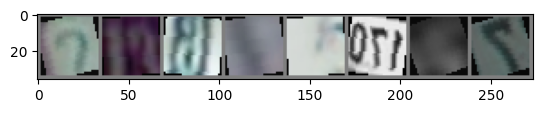

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


cifar_trainloader = DataLoader(cifar_trainset, batch_size=256, shuffle=True)
# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % classes[labels[j]] for j in range(8)))
plt.show()

print('SVHN')

dataiter = iter(svhn_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join('%8s' % labels[j].item() for j in range(8)))
plt.show()


In [7]:
learning_rate = 0.001
epochs = 5

model = torchvision.models.resnet18(pretrained = False) # let's initialize a ResNet18 from scratch and pretrain it ourselves
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)

model.to(device)
criterion = nn.CrossEntropyLoss()

# AdamW is an improved gradient descent algorithm
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Baseline result: Training a ResNet-18 from scratch on SVHN.

In [8]:
run_training(model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:30<00:00,  3.34it/s, Epoch=0, Valid_Acc=17, Valid_Loss=2.34]
Validation Accuracy Improved (0.0 ---> 16.97)

100%|██████████| 102/102 [00:30<00:00,  3.33it/s, Epoch=1, Valid_Acc=18.8, Valid_Loss=2.25]
Validation Accuracy Improved (16.97 ---> 18.79)

100%|██████████| 102/102 [00:30<00:00,  3.32it/s, Epoch=2, Valid_Acc=22, Valid_Loss=2.2]
Validation Accuracy Improved (18.79 ---> 21.99)

100%|██████████| 102/102 [00:30<00:00,  3.33it/s, Epoch=3, Valid_Acc=24.5, Valid_Loss=2.22]
Validation Accuracy Improved (21.99 ---> 24.46)

100%|██████████| 102/102 [00:30<00:00,  3.33it/s, Epoch=4, Valid_Acc=23.2, Valid_Loss=2.24]



## Baseline SVHN result is ... okish?

Can we do better?

YES!

Let's pretrain on CIFAR10 using SimCLR. First, let's define the SimCLR loss (contrastive loss).

Details are not important now. You can read the paper if you want to learn more.

In [9]:
class SimCLRLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)

        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):

        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()

        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

# helper stuff
def plot_features(model, dataloader, num_feats, batch_size):
    preds = np.array([]).reshape((0,1))
    gt = np.array([]).reshape((0,1))
    feats = np.array([]).reshape((0,num_feats))
    model.eval()
    with torch.no_grad():
        for i, (x1,x2) in enumerate(dataloader):
            x1 = x1.squeeze().to(device = device, dtype = torch.float)
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats, out, axis = 0)

            if i == 100:
              break

    tsne = TSNE(n_components = 2, perplexity = 50, verbose = 2)
    x_feats = tsne.fit_transform(feats)

    plt.scatter(x_feats[:, 1], x_feats[:, 0])
    plt.show()

Custom model wrapper to have a projection head.

In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class ModelForPretraining(nn.Module):
    def __init__(self, projector_size):
        super().__init__()

        self.pretrained = torchvision.models.resnet18(pretrained=False)

        self.pretrained.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
        self.pretrained.maxpool = Identity()
        self.pretrained.fc = Identity()

        for p in self.pretrained.parameters():
            p.requires_grad = True

        # TODO probably needs some adjusting, maybe it's too small?
        # TODO instead of a Linear layer, make it a MLP. Check the paper.
        self.projector = nn.Linear(512, projector_size, bias = True)

    def forward(self,x):
        out = self.pretrained(x)
        xp = self.projector(torch.squeeze(out))
        return xp

class ModelForFinetuning(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()

        self.premodel = pretrained_model
        self.num_classes = 10

        # Freeze the layers of the pretrained model

        # TODO Optionally freeze model parameters if you have a good model and train only the last layer
        for p in self.premodel.parameters():
            p.requires_grad = False

        for p in self.premodel.projector.parameters():
            p.requires_grad = False

        # Fine-tune only the last layer
        self.lastlayer = nn.Linear(512, self.num_classes)

    def forward(self,x):
        out = self.premodel.pretrained(x)
        out = self.lastlayer(out)
        return out

# SimCLR training loop
## Augment an image two ways and compute the contrastive loss with respect to the other images in the batch

In [11]:
class TwoViewsDataset(torch.utils.data.Dataset):
  def __init__(self, source_dataset):
    # WARNING !!!! This assumes the dataset outputs augmented images
    self.source_dataset = source_dataset

  def __len__(self):
    return len(self.source_dataset)

  def __getitem__(self, idx):
    # each time is a different augmentation of the same image
    view1, _ = self.source_dataset[idx]
    view2, _ = self.source_dataset[idx]

    return view1, view2

In [13]:
cifar_trainloader = DataLoader(TwoViewsDataset(source_dataset = cifar_trainset), batch_size=128, shuffle=True, drop_last = True)
cifar_testloader = DataLoader(TwoViewsDataset(source_dataset = cifar_testset), batch_size=128, shuffle=True, drop_last = True)


# TODO Usually train for a longer time. Way longer.
epochs = 5

model_for_pretraining = ModelForPretraining(projector_size = 256) # TODO might need some changes to the projector_size? Check the paper.
model_for_pretraining.to(device)

# TODO temperature might need some changes. Check the paper.
# TODO the batch size seems important. Usually, for contrastive learning, the bigger the batch size, the better. Check the paper.
criterion = SimCLRLoss(batch_size = 128, temperature = 1.0)
optimizer = optim.AdamW(model_for_pretraining.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print(f"Epoch [{epoch}/{epochs}]\t")
    model_for_pretraining.train()

    for step, (x_i, x_j) in enumerate(tqdm(cifar_trainloader, total = len(cifar_trainloader))):
        optimizer.zero_grad()

        x_i = x_i.squeeze().to(device).float()
        x_j = x_j.squeeze().to(device).float()

        # positive pair, with encoding
        z_i = model_for_pretraining(x_i)
        z_j = model_for_pretraining(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        if epoch == 0 and step % 25 == 0:
            print(f"Step [{step}/{len(cifar_trainloader)}]\t Train Loss: {round(loss.item(), 5)}")

    model_for_pretraining.eval()

    # Evaluation
    with torch.no_grad():
        val_loss_epoch = 0
        for step, (x_i, x_j) in enumerate(tqdm(cifar_testloader, total = len(cifar_testloader))):

          x_i = x_i.squeeze().to(device).float()
          x_j = x_j.squeeze().to(device).float()

          # positive pair, with encoding
          z_i = model_for_pretraining(x_i)
          z_j = model_for_pretraining(x_j)

          loss = criterion(z_i, z_j)

          if epoch == 0 and step % 25 == 0:
              print(f"Step [{step}/{len(cifar_testloader)}]\t Val Loss: {round(loss.item(),5)}")

          val_loss_epoch += loss.item()

    print(f"Epoch [{epoch}/{epochs}]")
    # TODO uncomment this to visualize clustering after each epoch. But it takes a long time time. Maybe do it every k epochs or something.
    plot_features(model_for_pretraining.pretrained, cifar_testloader, 512, 128)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [0/5]	


  0%|          | 1/390 [00:00<03:17,  1.97it/s]

Step [0/390]	 Train Loss: 5.51712


  7%|▋         | 26/390 [00:08<02:12,  2.75it/s]

Step [25/390]	 Train Loss: 5.07736


 13%|█▎        | 51/390 [00:17<02:05,  2.70it/s]

Step [50/390]	 Train Loss: 5.18117


 19%|█▉        | 76/390 [00:26<01:58,  2.65it/s]

Step [75/390]	 Train Loss: 5.1102


 26%|██▌       | 101/390 [00:35<02:06,  2.29it/s]

Step [100/390]	 Train Loss: 5.05782


 32%|███▏      | 126/390 [00:44<01:37,  2.72it/s]

Step [125/390]	 Train Loss: 5.06184


 39%|███▊      | 151/390 [00:53<01:29,  2.68it/s]

Step [150/390]	 Train Loss: 5.03737


 45%|████▌     | 176/390 [01:02<01:23,  2.57it/s]

Step [175/390]	 Train Loss: 5.023


 52%|█████▏    | 201/390 [01:10<01:13,  2.57it/s]

Step [200/390]	 Train Loss: 4.99782


 58%|█████▊    | 226/390 [01:19<01:01,  2.68it/s]

Step [225/390]	 Train Loss: 5.02312


 64%|██████▍   | 251/390 [01:28<00:51,  2.70it/s]

Step [250/390]	 Train Loss: 5.00439


 71%|███████   | 276/390 [01:37<00:47,  2.42it/s]

Step [275/390]	 Train Loss: 4.99985


 77%|███████▋  | 301/390 [01:45<00:32,  2.70it/s]

Step [300/390]	 Train Loss: 5.05304


 84%|████████▎ | 326/390 [01:54<00:23,  2.73it/s]

Step [325/390]	 Train Loss: 4.98206


 90%|█████████ | 351/390 [02:03<00:14,  2.69it/s]

Step [350/390]	 Train Loss: 5.05098


 96%|█████████▋| 376/390 [02:12<00:06,  2.33it/s]

Step [375/390]	 Train Loss: 5.00865


  1%|▏         | 1/78 [00:00<00:23,  3.29it/s]

Step [0/78]	 Val Loss: 5.00664


 33%|███▎      | 26/78 [00:08<00:18,  2.82it/s]

Step [25/78]	 Val Loss: 4.9758


 65%|██████▌   | 51/78 [00:17<00:08,  3.01it/s]

Step [50/78]	 Val Loss: 5.01051


 97%|█████████▋| 76/78 [00:26<00:00,  3.01it/s]

Step [75/78]	 Val Loss: 4.99084


100%|██████████| 78/78 [00:26<00:00,  2.91it/s]


Epoch [0/5]
Epoch [1/5]	


100%|██████████| 78/78 [00:27<00:00,  2.81it/s]


Epoch [1/5]
Epoch [2/5]	


100%|██████████| 78/78 [00:26<00:00,  2.94it/s]


Epoch [2/5]
Epoch [3/5]	


100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


Epoch [3/5]
Epoch [4/5]	


100%|██████████| 78/78 [00:26<00:00,  2.91it/s]

Epoch [4/5]


## Model fine-tuning on 10% of SVHN

In [16]:
downstream_model = ModelForFinetuning(pretrained_model = model_for_pretraining)
downstream_model.to(device)

criterion = nn.CrossEntropyLoss()

# Adam is an improved gradient descent algorithm
optimizer = optim.Adam(downstream_model.parameters(), lr=0.001)

run_training(downstream_model, svhn_trainloader, svhn_testloader, criterion = criterion, optimizer = optimizer, num_epochs = epochs)

[INFO] Using GPU: Tesla T4

100%|██████████| 102/102 [00:35<00:00,  2.90it/s, Epoch=0, Valid_Acc=27, Valid_Loss=2.06]
Validation Accuracy Improved (0.0 ---> 27.02)

100%|██████████| 102/102 [00:35<00:00,  2.89it/s, Epoch=1, Valid_Acc=28.4, Valid_Loss=2.04]
Validation Accuracy Improved (27.02 ---> 28.35)

100%|██████████| 102/102 [00:35<00:00,  2.87it/s, Epoch=2, Valid_Acc=28.6, Valid_Loss=2.04]
Validation Accuracy Improved (28.35 ---> 28.61)

100%|██████████| 102/102 [00:35<00:00,  2.89it/s, Epoch=3, Valid_Acc=27.8, Valid_Loss=2.05]

100%|██████████| 102/102 [00:35<00:00,  2.89it/s, Epoch=4, Valid_Acc=28.7, Valid_Loss=2.04]
Validation Accuracy Improved (28.61 ---> 28.67)



## We have improved results!

#### If not, add more augmentations, pretrain for longer. Check the paper for more insights.